In [266]:
import os
import sys
import torch
import random
import argparse
from torch import nn
from torch.nn import functional
from torch import optim
from tqdm import tqdm
from tabulate import tabulate
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GATv2Conv, global_mean_pool
from torch_geometric.loader import DataLoader
from fairmofsyncondition.read_write import coords_library, filetyper

class EnergyGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, edge_dim, heads=4, dropout=0.2):
        super(EnergyGNN, self).__init__()
        input_dim = int(input_dim)
        hidden_dim = int(hidden_dim)
        output_dim = int(output_dim)
        edge_dim = int(edge_dim)
        heads = int(heads)
        self.conv1 = GATv2Conv(input_dim, hidden_dim,
                               heads=heads, edge_dim=edge_dim)
        self.norm1 = nn.BatchNorm1d(hidden_dim * heads)
        self.conv2 = GATv2Conv(
            hidden_dim * heads, hidden_dim, heads=heads, edge_dim=edge_dim)
        self.norm2 = nn.BatchNorm1d(hidden_dim * heads)
        self.conv3 = GATv2Conv(
            hidden_dim * heads, hidden_dim, heads=heads, edge_dim=edge_dim)
        self.norm3 = nn.BatchNorm1d(hidden_dim * heads)
        self.fc1 = nn.Linear(hidden_dim * heads, hidden_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = functional.leaky_relu(self.norm1(
            self.conv1(x, edge_index, edge_attr)))
        x = functional.leaky_relu(self.norm2(
            self.conv2(x, edge_index, edge_attr)))
        x = functional.leaky_relu(self.norm3(
            self.conv3(x, edge_index, edge_attr)))
        x = global_mean_pool(x, batch)
        x = functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in dataloader:
        data.lattice = data.lattice.reshape(-1,3,3)
        data = data.to(device)
        optimizer.zero_grad()
        predictions = model(data).view(-1)
        loss = criterion(predictions, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)



def normalize_data(dataset, method='min-max'):
    y_values = torch.cat([data.y for data in dataset])  # Gather all target values
    if method == 'min-max':
        y_min, y_max = y_values.min(), y_values.max()
        for data in dataset:
            data.y = (data.y - y_min) / (y_max - y_min)
        return dataset, {'min': y_min, 'max': y_max}

    elif method == 'z-score':
        y_mean, y_std = y_values.mean(), y_values.std()
        for data in dataset:
            data.y = (data.y - y_mean) / y_std
        return dataset, {'mean': y_mean, 'std': y_std}

    else:
        raise ValueError("Unsupported normalization method. Choose 'min-max' or 'z-score'.")


def inverse_normalize(predictions, normalization_params, method='min-max'):
    if method == 'min-max':
        return predictions * (normalization_params['max'] - normalization_params['min']) + normalization_params['min']
    elif method == 'z-score':
        return predictions * normalization_params['std'] + normalization_params['mean']
    else:
        raise ValueError("Unsupported normalization method. Choose 'min-max' or z-score")

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for data in dataloader:
            data.lattice = data.lattice.reshape(-1,3,3)
            data = data.to(device)
            labels = data.y
            predictions = model(data).view(-1)
            loss = criterion(predictions, labels)
            total_loss += loss.item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(dataloader)

    return average_loss


def save_model(model, optimizer, normalise_parameter, path="model.pth"):
    """
    Save the trained model and optimizer state to a file.

    **parameters:**
        model (nn.Module): The trained GNN model to save.
        optimizer (optim.Optimizer): Optimizer for updating model parameters.
        path (str, optional): Path to save the model. Default is "model.pth".
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'model_architecture': model.__class__,
        'model_args': model.__dict__.get('_modules'),
        'normalise_parameter': normalise_parameter
    }
    torch.save(checkpoint, path)


def load_model(path="model.pth", device="cpu"):
    """
    Load a saved model and optimizer state from a file.

    **parameters:**
        path (str, optional): Path to load the model. Default is "model.pth".
        device (torch.device, optional): The device (CPU or GPU) for computation. Default is "cpu".

    **returns:**
        tuple: The loaded model and optimizer.
    """
    checkpoint = torch.load(path, map_location=device)
    model_class = checkpoint['model_architecture']
    model_args = checkpoint['model_args']
    normalise_parameter = checkpoint['normalise_parameter']
    model = model_class(**model_args).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])

    optimizer = optim.Adam(model.parameters())  # Rebuild the optimizer
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer, normalise_parameter

def transform_target(test_data, normalize_param, method='min-max'):
    """
    Transform the target values in the test dataset according to the normalization parameters.

    Parameters:
        test_data (Dataset): The test dataset containing the target values.
        normalize_param (dict): The normalization parameters (mean and std).
        method (str, optional): The normalization method ('z-score' or'min-max'). Default is 'z-score'.

    Returns:
        Dataset: The transformed test dataset.
    """
    if method == 'z-score':
        mean, std = normalize_param['mean'], normalize_param['std']
        for data in test_data:
            data.y = (data.y - mean) / std
    elif method =='min-max':
        min_val, max_val = normalize_param['min'], normalize_param['max']
        for data in test_data:
            data.y = (data.y - min_val) / (max_val - min_val)
    else:
        raise ValueError("Unsupported normalization method. Choose 'z-score' or'min-max'.")
    return test_data


def load_dataset(path_to_lmdb, batch_size, train_size=0.9, random_seed=42, shuffle=True, normalize='full'):
    """
    Loads a dataset from an LMDB file and splits it into training, validation, and test sets.

    The function uses the `coords_library.LMDBDataset` to load the dataset and splits it into
    training and test datasets. The training dataset is further split into training and validation
    sets. Data loaders are created for the training and validation datasets.

    Parameters:
        path_to_lmdb (str):
            Path to the LMDB file containing the dataset.
        batch_size (int):
            Batch size for the DataLoader.
        train_size (float, optional):
            Fraction of the data to use for training. The rest is used for testing. Default is 0.8.
        random_seed (int, optional):
            Random seed for splitting the data. Ensures reproducibility. Default is 42.
        shuffle (bool, optional):
            Whether to shuffle the data before splitting. Default is True.
        normalize (str, optional):
            Normalization method to use. Can be 'full' for full normalization or 'batch' for
            batch normalization. Default is 'full'.

    Returns:
        tuple:
            - train_loader (DataLoader): DataLoader for the training dataset.
            - val_loader (DataLoader): DataLoader for the validation dataset.
            - test_dataset (Dataset): Dataset object containing the test data.
    """
    dataset = coords_library.LMDBDataset(path_to_lmdb)
    train_dataset, test_dataset = dataset.split_data(
        train_size=train_size, random_seed=random_seed, shuffle=shuffle)

    train_indices, val_indices = coords_library.list_train_test_split(list(range(len(train_dataset))))
    train_data = train_dataset[train_indices]
    val_data = train_dataset[val_indices]
    if normalize == 'full':
        train_data_norm, normalise_parameter = normalize_data(train_data)
        train_loader = DataLoader(train_data_norm, batch_size=batch_size, shuffle=True)
        val_data = transform_target(val_data, normalise_parameter)
        test_dataset = transform_target(test_dataset, normalise_parameter)
    elif normalize == 'batch':
        print("error")
        train_loader = DataLoader(train_data_norm, batch_size=batch_size, shuffle=True)
        train_loader, normalise_parameter = normalize_data(train_loader)
        val_data = transform_target(val_data, normalise_parameter)
        test_dataset = transform_target(test_dataset, normalise_parameter)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_dataset, normalise_parameter

In [267]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001, path='checkpoint.pth'):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [268]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool, BatchNorm, global_max_pool, global_add_pool

class EnergyGNN_GIN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, edge_dim=None, heads=None, dropout=0.2):
        super(EnergyGNN_GIN, self).__init__()
        input_dim = int(input_dim)
        hidden_dim = int(hidden_dim)
        output_dim = int(output_dim)

        # Define MLPs for GINConv layers
        self.mlp1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv1 = GINConv(self.mlp1)

        self.mlp2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv2 = GINConv(self.mlp2)

        self.mlp3 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv3 = GINConv(self.mlp3)

        # Batch normalization layers
        self.norm1 = BatchNorm(hidden_dim)
        self.norm2 = BatchNorm(hidden_dim)
        self.norm3 = BatchNorm(hidden_dim)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Apply GIN layers with normalization and ReLU activations
        x = F.relu(self.norm1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.norm2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.norm3(self.conv3(x, edge_index)))
        x = self.dropout(x)

        # Global mean pooling
        x = global_mean_pool(x, batch)  # Mean pooling
       
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.relu(x)


In [317]:
class GraphLatticeModel(nn.Module):
    def __init__(self, input_dim, gnn_hidden_dim, lattice_hidden_dim, output_dim, dropout=0.2):
        super(GraphLatticeModel, self).__init__()
        input_dim = int(input_dim)
        hidden_dim = int(gnn_hidden_dim)
        lattice_hidden_dim = int(lattice_hidden_dim)
        output_dim = int(output_dim)

        # Define MLPs for GINConv layers
        self.mlp1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv1 = GINConv(self.mlp1)

        self.mlp2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv2 = GINConv(self.mlp2)

        self.mlp3 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv3 = GINConv(self.mlp3)

        # Batch normalization layers
        self.norm1 = BatchNorm(hidden_dim)
        self.norm2 = BatchNorm(hidden_dim)
        self.norm3 = BatchNorm(hidden_dim)

        # MLP part for lattice matrix processing
        self.mlp = nn.Sequential(
            nn.Linear(9, lattice_hidden_dim),  # Lattice matrix flattened (3x3 = 9)
            nn.ReLU(),
            nn.Linear(lattice_hidden_dim, lattice_hidden_dim),
            nn.ReLU()
        )
        
        # Fully connected layers for final prediction
        combined_dim = gnn_hidden_dim + lattice_hidden_dim
        self.fc1 = nn.Linear(combined_dim, gnn_hidden_dim)
        self.fc2 = nn.Linear(gnn_hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        lattice = data.lattice.view(data.lattice.size(0), -1)  # Flatten lattice matrix

        # Apply GIN layers with normalization and ReLU activations
        x = F.relu(self.norm1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.norm2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.norm3(self.conv3(x, edge_index)))
        x = self.dropout(x)

        # Global mean pooling
        x = global_mean_pool(x, batch)  # Mean pooling
       
       
       
        # MLP processing of lattice matrix
        lattice_rep = self.mlp(lattice)
        
        # Concatenate graph and lattice representations
        combined_rep = torch.cat([x, lattice_rep], dim=1)
        
        # Fully connected layers with dropout
        combined_rep = F.relu(self.fc1(combined_rep))
        combined_rep = self.dropout(combined_rep)
        out = self.fc2(combined_rep)
        
        out = torch.tanh(out) * 0.5 + 0.5
        return out

In [373]:
class GraphLatticeModel(nn.Module):
    def __init__(self, input_dim, gnn_hidden_dim, lattice_hidden_dim, output_dim, num_layers=3, dropout=0.2):
        super(GraphLatticeModel, self).__init__()
        input_dim = int(input_dim)
        hidden_dim = int(gnn_hidden_dim)
        lattice_hidden_dim = int(lattice_hidden_dim)
        output_dim = int(output_dim)
        num_layers = int(num_layers)

        # Define GINConv layers, their MLPs, and batch normalization dynamically
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for i in range(num_layers):
            mlp = nn.Sequential(
                nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(mlp))
            self.norms.append(BatchNorm(hidden_dim))

        # MLP part for lattice matrix processing
        self.mlp = nn.Sequential(
            nn.Linear(9, lattice_hidden_dim),  # Lattice matrix flattened (3x3 = 9)
            nn.ReLU(),
            nn.Linear(lattice_hidden_dim, lattice_hidden_dim),
            nn.ReLU()
        )

        # Fully connected layers for final prediction
        combined_dim = gnn_hidden_dim + lattice_hidden_dim
        self.fc1 = nn.Linear(combined_dim, gnn_hidden_dim)
        self.fc2 = nn.Linear(gnn_hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        lattice = data.lattice.view(data.lattice.size(0), -1)  # Flatten lattice matrix

        # Apply GIN layers with normalization and ReLU activations
        for conv, norm in zip(self.convs, self.norms):
            x = F.relu(norm(conv(x, edge_index)))
            x = self.dropout(x)

        # Global mean pooling
        x = global_mean_pool(x, batch)  # Mean pooling

        # MLP processing of lattice matrix
        lattice_rep = self.mlp(lattice)

        # Concatenate graph and lattice representations
        combined_rep = torch.cat([x, lattice_rep], dim=1)

        # Fully connected layers with dropout
        combined_rep = F.relu(self.fc1(combined_rep))
        combined_rep = self.dropout(combined_rep)
        out = self.fc2(combined_rep)

        # Scale output to [0, 1]
        out = torch.tanh(out) * 0.5 + 0.5
        return out


In [396]:
path_to_lmdb = "../test_data.lmdb"
train_size=0.9
random_seed=42
shuffle=True
normalize='full'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')






hidden_dim = 256    # 64 128
lattice_hidden_dim = 5
learning_rate = 0.001  # 0.1 0.01 0.0001
dropout = 0.1 # 0.2 0.3 0.4
epoch =  1500
batch_size = 2048  # 2048 4000 8000 16000 #depndes on your gpu


print_every = 10
patience = 100

In [397]:

# Initialize early stopping
early_stopping = EarlyStopping(patience=patience, path='best_model.pth')



#model = EnergyGNN(input_dim=4, hidden_dim=hidden_dim,
#                    output_dim=1, edge_dim=1, heads=heads, dropout=dropout).to(device)
#model = EnergyGNN_GIN(input_dim=4, hidden_dim=hidden_dim,
#                    output_dim=1, edge_dim=1, heads=heads, dropout=dropout).to(device)


model = GraphLatticeModel(input_dim=4, 
                          gnn_hidden_dim=hidden_dim, 
                          lattice_hidden_dim=lattice_hidden_dim, 
                          output_dim=1, 
                          num_layers= 2,
                          dropout=dropout).to(device)


optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00001)
#criterion = nn.MSELoss()
#criterion = nn.SmoothL1Loss()
criterion = nn.L1Loss()


train_loader, val_loader, test_dataset, normalise_parameter = load_dataset(path_to_lmdb, batch_size)

# Training loop with early stopping
for i in range(epoch):
    train_loss = train(model, train_loader, optimizer, criterion, device)

    val_loss = evaluate(model, val_loader, criterion, device)
    
    # Check for early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break
    if i % print_every == 0:
        print(f"Epoch: {i+1}/{epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
val_loss = evaluate(model, val_loader, criterion, device)
print("Loaded the best model saved during training.",val_loss)

Epoch: 1/1500, Train Loss: 0.1793, Val Loss: 0.2209
Epoch: 11/1500, Train Loss: 0.1546, Val Loss: 0.2198
Epoch: 21/1500, Train Loss: 0.1458, Val Loss: 0.1739
Epoch: 31/1500, Train Loss: 0.1401, Val Loss: 0.1856
Epoch: 41/1500, Train Loss: 0.1339, Val Loss: 0.1655
Epoch: 51/1500, Train Loss: 0.1285, Val Loss: 0.1618
Epoch: 61/1500, Train Loss: 0.1257, Val Loss: 0.1615
Epoch: 71/1500, Train Loss: 0.1179, Val Loss: 0.1626
Epoch: 81/1500, Train Loss: 0.1144, Val Loss: 0.1614
Epoch: 91/1500, Train Loss: 0.1137, Val Loss: 0.1605
Epoch: 101/1500, Train Loss: 0.1126, Val Loss: 0.1616
Epoch: 111/1500, Train Loss: 0.1042, Val Loss: 0.1587
Epoch: 121/1500, Train Loss: 0.0992, Val Loss: 0.1600
Epoch: 131/1500, Train Loss: 0.0988, Val Loss: 0.1589
Epoch: 141/1500, Train Loss: 0.0954, Val Loss: 0.1573
Epoch: 151/1500, Train Loss: 0.0925, Val Loss: 0.1589
Epoch: 161/1500, Train Loss: 0.0934, Val Loss: 0.1636
Epoch: 171/1500, Train Loss: 0.0880, Val Loss: 0.1574
Epoch: 181/1500, Train Loss: 0.0929, Va

In [398]:
dataloader = val_loader

def get_pred(dataloader,model):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    preds = []
    ys = []
    with torch.no_grad():
        for data in dataloader:
            data.lattice = data.lattice.reshape(-1,3,3)
            data = data.to(device)
            labels = data.y
            predictions = model(data).view(-1)
            preds.extend(predictions.detach().cpu().numpy().tolist())
            ys.extend(labels.detach().cpu().numpy().tolist())
    return preds,ys
        
from sklearn.metrics import mean_absolute_error




preds,ys = get_pred(val_loader,model)
print(mean_absolute_error(ys,preds))
preds,ys = get_pred(train_loader,model)
print(mean_absolute_error(ys,preds))

0.15214808512375586
0.09219577375398431


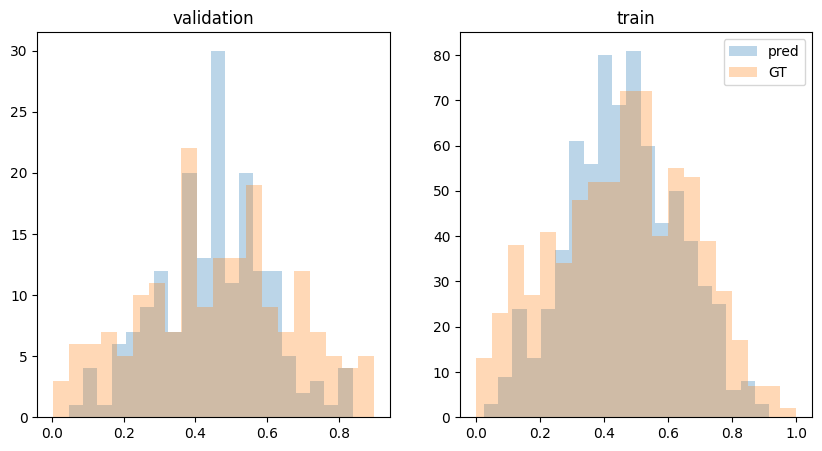

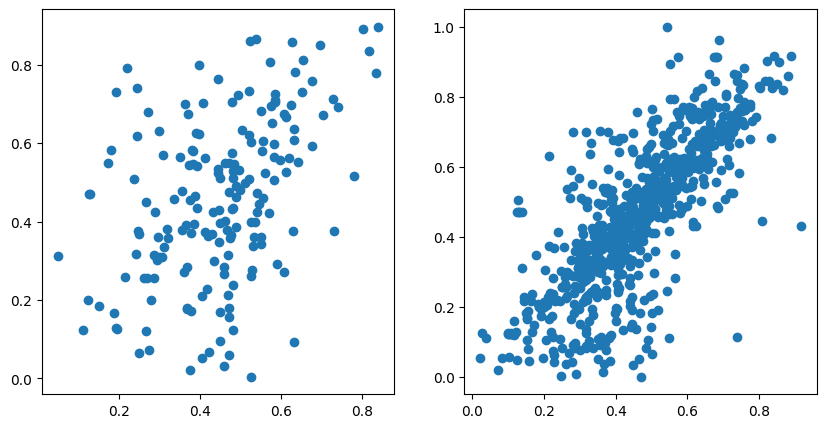

In [399]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,5))
plt.subplot(121)
preds,ys = get_pred(val_loader,model)
plt.hist(preds,bins=20,alpha=0.3,label="pred")
plt.hist(ys,bins=20,alpha=0.3,label="GT")
plt.title("validation")
plt.subplot(122)
preds,ys = get_pred(train_loader,model)
plt.hist(preds,bins=20,alpha=0.3,label="pred")
plt.hist(ys,bins=20,alpha=0.3,label="GT")
plt.title("train")
plt.legend()
plt.show()



plt.figure(figsize=(10,5))
plt.subplot(121)
preds,ys = get_pred(val_loader,model)
plt.scatter(preds,ys)
plt.subplot(122)
preds,ys = get_pred(train_loader,model)
plt.scatter(preds,ys)